### Testing how to reproject data from an xarray

rioxarray https://corteva.github.io/rioxarray/stable/ (rasterio and .tif files)

pyresample https://pyresample.readthedocs.io/en/latest/ 

plotting with pyresample, some very cool representations https://pyresample.readthedocs.io/en/latest/howtos/plot.html

In [143]:
#
import xarray as xr
import rioxarray
import pyresample
import sys

sys.path.append("../")

from src.processing import windsat_datacube

In [144]:
# This only works with rasterio reading (tiff files)
from rasterio.enums import Resampling

# Open a .tif file with rasterio
ds = rioxarray.open_rasterio(r"..\data\raw\AMSRU_Mland_2017001A.tif", masked=True)
print("Original sizes")
print(ds.sizes)
print(ds.rio.crs)

# resampling
rds = ds.rio.reproject(
    ds.rio.crs,
    shape=(720, 1440),
    resampling=Resampling.bilinear,
)
print("Reprojected sizes")
print(rds.sizes)
print(rds.rio.crs)

Original sizes
Frozen({'band': 7, 'y': 586, 'x': 1383})
EPSG:6933
Reprojected sizes
Frozen({'band': 7, 'y': 720, 'x': 1440})
EPSG:6933


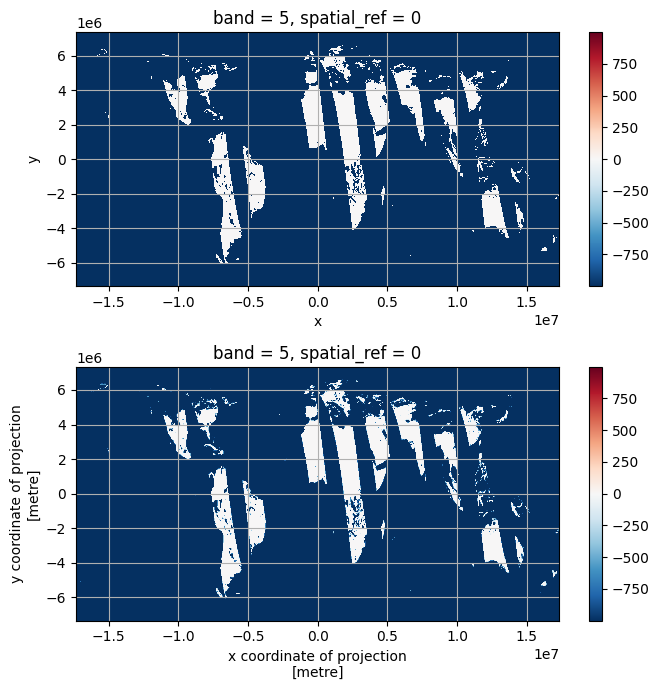

In [145]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ds.sel(band=5).plot(ax=ax[0], label="Original")
rds.sel(band=5).plot(ax=ax[1], label="Reprojected")
ax[0].grid()
ax[1].grid()

fig.tight_layout()

In [152]:
# Reprojecting Xarray datasets in .nc files
ds = xr.open_dataset(
    "../data/raw/Daily_Windsat/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_01.nc",
    decode_times=False,
)

# rename lat and lon grid to x and y:
ds = ds.rename({"longitude_grid": "x", "latitude_grid": "y"})

# Se the original CRS since the data array does not have it in metadata:
ds = ds.rio.write_crs("EPSG:4326")

# Set the x and y dimensions as coordinates
ds = ds.set_coords(names=["longitude", "latitude"])
ds = ds.rename({"longitude": "x", "latitude": "y"})
# Only avaialble with 2D or 3D arrays, we need to select each variable individually
ds_var = ds["tbtoa"].sel(
    polarization=0, swath_sector=1, frequency_band=0, look_direction=0
)

rds = ds_var.rio.reproject("EPSG:6933", resolution=25000)  # In meters!
rds

C:\Users\andre\AppData\Local\Temp\ipykernel_2664\526612598.py:15: UserWarning: rename 'longitude' to 'x' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"longitude": "x", "latitude": "y"})
C:\Users\andre\AppData\Local\Temp\ipykernel_2664\526612598.py:15: UserWarning: rename 'latitude' to 'y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"longitude": "x", "latitude": "y"})


<xarray.DataArray 'tbtoa' (y: 588, x: 1389)> Size: 3MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [253.89   , 253.9075 , 253.8875 , ..., 253.84   , 253.89249,
        253.9125 ],
       [251.10999, 251.0975 , 251.0725 , ..., 251.34749, 251.1975 ,
        251.15   ],
       ...,
       [225.33249, 225.1825 , 224.98999, ...,       nan, 225.70749,
        225.54   ],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * x            (x) float64 11kB -1.736e+07 -1.733e+07 ... 1.732e+07 1.734e+07
  * y            (y) float64 5kB 7.33e+06 7.305e+06 ... -7.32e+06 -7.345e+06
    spatial_ref  int32 4B 0
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement

In [153]:
ds["tbtoa"]

<xarray.DataArray 'tbtoa' (polarization: 4, frequency_band: 5, y: 720, x: 1440,
                           look_direction: 2, swath_sector: 2)> Size: 332MB
[82944000 values with dtype=float32]
Coordinates:
    x            (x) float32 6kB ...
    y            (y) float32 3kB ...
    spatial_ref  int32 4B 0
Dimensions without coordinates: polarization, frequency_band, look_direction,
                                swath_sector
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement

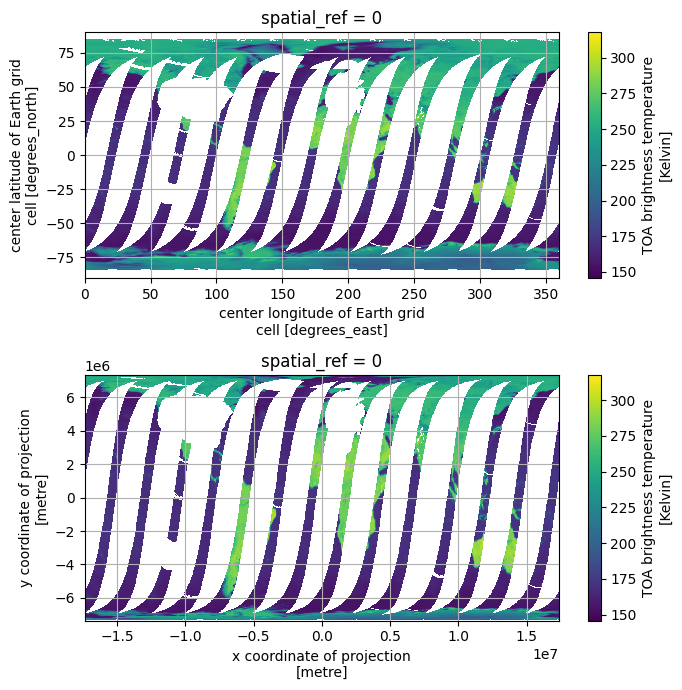

In [154]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ds["tbtoa"].sel(polarization=0, swath_sector=1, frequency_band=0, look_direction=0).roll({"x":4*180}).plot(ax=ax[0], label="Original")
rds.plot(ax=ax[1], label="Reprojected")
ax[0].grid()
ax[1].grid()

fig.tight_layout()